[Elliptical Galaxies](#1)
[Disk Galaxies](#2)
[Symbolic Regression - SR](#3)
[SR Elliptical Galaxies](#4)
#### <font color='purple'>  [SR Disk Galaxies](#5)

### This code provides the prdictions, feature ranking and a plot of true vs predicted values of galaxy sizes  independent datasets divided by galaxy morphology: disks vs ellipticals



In [2]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

from pysr import PySRRegressor


In [3]:
import target_predicting_ML_functions_and_feature_ranking as functions

In [21]:
import pysr
pysr.install()

[ Info: Julia version info


Julia Version 1.8.0-rc1
Commit 6368fdc6565 (2022-05-27 18:33 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.3.0)
  uname: Darwin 21.2.0 Darwin Kernel Version 21.2.0: Sun Nov 28 20:29:10 PST 2021; root:xnu-8019.61.5~1/RELEASE_ARM64_T8101 x86_64 i386
  CPU: Apple M1: 
              speed         user         nice          sys         idle          irq
       #1    24 MHz     315973 s          0 s     137283 s    1568945 s          0 s
       #2    24 MHz     304226 s          0 s     124266 s    1593541 s          0 s
       #3    24 MHz     278869 s          0 s      98515 s    1644650 s          0 s
       #4    24 MHz     263348 s          0 s      78773 s    1679914 s          0 s
       #5    24 MHz     428519 s          0 s      23467 s    1570045 s          0 s
       #6    24 MHz     379223 s          0 s      16801 s    1626009 s          0 s
       #7    24 MHz     338509 s          0 s       9931 s    1673597 s          0 s
       #8    24 MHz     317856 s          0 s 

[ Info: Julia executable: /Applications/Julia-1.8.app/Contents/Resources/julia/bin/julia
[ Info: Trying to import PyCall...
┌ Error: `import PyCall` failed
│   exception =
│    ArgumentError: Package PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0] is required but does not seem to be installed:
│     - Run `Pkg.instantiate()` to install all recorded dependencies.
│    
│    Stacktrace:
│     [1] _require(pkg::Base.PkgId)
│       @ Base ./loading.jl:1172
│     [2] _require_prelocked(uuidkey::Base.PkgId)
│       @ Base ./loading.jl:1091
│     [3] macro expansion
│       @ ./lock.jl:223 [inlined]
│     [4] require(uuidkey::Base.PkgId)
│       @ Base ./loading.jl:1086
│     [5] top-level scope
│       @ ~/miniforge3/envs/native/lib/python3.9/site-packages/julia/install.jl:36
│     [6] include(mod::Module, _path::String)
│       @ Base ./Base.jl:422
│     [7] exec_options(opts::Base.JLOptions)
│       @ Base ./client.jl:303
│     [8] _start()
│       @ Base ./client.jl:522
└ @ Main ~/miniforge

#### <font color='violet'> ML modelling with 33 galaxy and halo features; df from v5 used here


#### Read the normalized 31-feature dataset (see explanations in related doc 'TNG-SAM 33-feature analysis')

In [4]:
df_normalized_31 = pd.read_csv('Halo Mass Normalized Dataset w 31 features.csv')

#### Add the column 'BulgeMstar_ratio' defined as Bulge mass / Stellar mass, to be used as a proxy for galaxy morphology

In [5]:
df_normalized_31.loc[:, 'BulgeMstar_ratio'] = df_normalized_31.loc[:,'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar']


In [6]:
df_normalized_31.shape

(35390, 33)

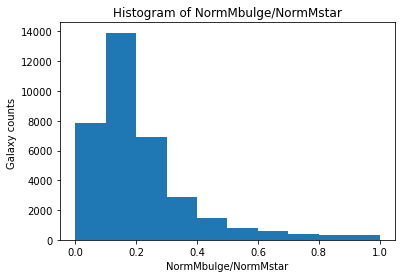

In [7]:
plt.hist(df_normalized_31['BulgeMstar_ratio'])
plt.title('Histogram of NormMbulge/NormMstar')
plt.xlabel('NormMbulge/NormMstar')
plt.ylabel('Galaxy counts ')
# plt.savefig('Histogram of GalpropNormMbulgebyNormMstar.jpg', dpi=500)

plt.show()


## <font color='purple'> <a id =1> </a> <br> Elliptical Galaxies

In [8]:
df_ellipticals = pd.read_csv('Ellipticals Dataset_as defined in notebook v13')

In [9]:
df_ellipticals.shape

(2422, 33)

In [10]:
X_ellipticals = df_ellipticals.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio'])


y_ellipticals = df_ellipticals.loc[:,'GalpropNormHalfRadius']

## <font color='purple'> <a id =2> </a> <br>Disk Galaxies

In [11]:
df_disks = pd.read_csv('Disks Dataset_as defined in notebook v13')

In [12]:
df_disks.shape

(15717, 33)

In [13]:
X_disks = df_disks.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio'])


y_disks = df_disks.loc[:,'GalpropNormHalfRadius']

--------------------

## <font color='darkviolet'> <a id =3> </a> <br>Symbolic Regression - SR

## <font color='purple'> <a id =4> </a> <br> SR Elliptical Galaxies

In [13]:
# choose only the 4 most important features from feature ranking in notebook v13,
# in order to reduce the time to run SR modelling

X_ellipticals_imp = X_ellipticals.loc[:, ['GalpropNormSigmaBulge', 'GalpropNormMstar',
                                                  'GalpropNormMstar_merge', 'HalopropSpin']]


y_ellipticals_imp = y_ellipticals

In [19]:
# choose the Symbolic Regression model; choose the mathematical operations allowed
model_ellipticals_imp = PySRRegressor(
    niterations=50,
    binary_operators=["+", "*", "pow", ],
    unary_operators=["exp", "square", "cube"
#         "inv(x) = 1/x",  # Custom operator (julia syntax)
         ],
        constraints={
        "pow": (-1, 1),
#         "sqrt": 5,
    },
    
    maxsize=30,
    multithreading=False,
    model_selection="best",
    loss="loss(x, y) = (x - y)^2"  # Custom loss function (julia syntax)

)

In [20]:
start_time = time.time()

model_ellipticals_imp.fit(X_ellipticals_imp, np.array(y_ellipticals_imp))

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the SymbolicRegression fitting: {elapsed_time:.3f} seconds")

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pysr/sr.py:1067: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Activating environment on workers.
      From worker 10:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 17:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 12:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 16:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 13:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 11:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 15:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 14:	  Activating project at `~/.julia/environments/pysr-0.9.3`
Importing installed module on workers...      From worker 15:	WARNING: ignoring conflicting import of CoreModule.div into SymbolicRegression
      From worker 12:	WARNING: ignoring conflicting import of CoreModule.div into SymbolicRegression
      From worker 11:	WARNING: ignoring conflicting import of CoreModule.di

19          4.248e+01  8.614e-02  cube(exp(square(pow(0.50415033, GalpropNormSigmaBulge) * (pow(GalpropNormMstar * square(pow(GalpropNormMstar_merge, GalpropNormMstar) * 3.829915), 0.5592326) + 1.2827065))))
20          3.828e+01  1.041e-01  cube(exp(square(pow(0.46854416, GalpropNormSigmaBulge) * (pow(GalpropNormMstar * square(pow(square(GalpropNormMstar_merge), GalpropNormMstar) * 6.0755434), 0.52797383) + 1.16752))))
22          3.827e+01  8.891e-05  (cube(exp(square(pow(0.46854416, GalpropNormSigmaBulge) * (pow(GalpropNormMstar * square(pow(square(GalpropNormMstar_merge), GalpropNormMstar) * 6.0755434), 0.52797383) + 1.16752)))) + GalpropNormMstar)
23          3.804e+01  6.160e-03  cube(exp(square(pow(0.46854416, GalpropNormSigmaBulge) * (pow(GalpropNormMstar * square(pow(square(GalpropNormMstar_merge), GalpropNormMstar) * 6.0755434), 0.52797383) + 1.16752)) + square(HalopropSpin)))
25          3.783e+01  2.755e-03  cube(exp(square(pow(0.46854416, GalpropNormSigmaBulge) * (pow(Galp

In [21]:
print(model_ellipticals_imp)

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                            9.87485   
	1         0.000088                (GalpropNormMstar_merge + 9.870772)   
	2         0.001724           cube(2.1304216 + GalpropNormMstar_merge)   
	3   >>>>  0.498623  (pow(GalpropNormSigmaBulge, -1.9748428) * 8.38...   
	4         0.000540  square(cube(exp(pow(-0.34436056, GalpropNormSi...   
	5         0.013385  cube(square(pow(0.66508913, GalpropNormSigmaBu...   
	6         0.001077  square(cube(exp(pow(0.3402019, GalpropNormSigm...   
	7         0.032654  square(cube(pow(-0.66880566, GalpropNormSigmaB...   
	8         0.030902  cube(square(pow(0.6610971, GalpropNormSigmaBul...   
	9         0.126765  cube(exp(square(pow(0.55914974, GalpropNormSig...   
	10        0.020401  cube(exp(square(pow(0.55914974, GalpropNormSig...   
	11        0.006161  (cube(exp(pow(0.44222236, GalpropNormSigmaBulg...   
	12      

In [22]:
model_ellipticals_imp.equations_

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,116.389725,0.000000,9.87485,9.87485000000000,PySRFunction(X=>9.87485000000000)
1,3,116.369350,0.000088,(GalpropNormMstar_merge + 9.870772),GalpropNormMstar_merge + 9.870772,PySRFunction(X=>GalpropNormMstar_merge + 9.870...
2,4,116.168870,0.001724,cube(2.1304216 + GalpropNormMstar_merge),9.66933640699546*(0.469390659576489*GalpropNor...,PySRFunction(X=>9.66933640699546*(0.4693906595...
3,5,70.557070,0.498623,"(pow(GalpropNormSigmaBulge, -1.9748428) * 8.38...",8.381839/Abs(GalpropNormSigmaBulge)**1.9748428,PySRFunction(X=>8.381839/Abs(GalpropNormSigmaB...
4,6,70.518980,0.000540,"square(cube(exp(pow(-0.34436056, GalpropNormSi...",exp(6*0.34436056**GalpropNormSigmaBulge),PySRFunction(X=>exp(6*0.34436056**GalpropNormS...
5,7,69.581390,0.013385,"cube(square(pow(0.66508913, GalpropNormSigmaBu...",96.2902212218453*0.66508913**(6*GalpropNormSig...,PySRFunction(X=>96.2902212218453*0.66508913**(...
6,8,69.506485,0.001077,"square(cube(exp(pow(0.3402019, GalpropNormSigm...",exp(6*0.3402019**GalpropNormSigmaBulge + 6*Gal...,PySRFunction(X=>exp(6*0.3402019**GalpropNormSi...
7,9,67.273480,0.032654,"square(cube(pow(-0.66880566, GalpropNormSigmaB...",93.4960665516478*0.66880566**(6*GalpropNormSig...,PySRFunction(X=>93.4960665516478*0.66880566**(...
8,11,63.241560,0.030902,"cube(square(pow(0.6610971, GalpropNormSigmaBul...",93.4960665516478*0.6610971**(6*GalpropNormSigm...,PySRFunction(X=>93.4960665516478*0.6610971**(6...
9,12,55.712067,0.126765,"cube(exp(square(pow(0.55914974, GalpropNormSig...",exp(5.34172756703052*0.55914974**(2*GalpropNor...,PySRFunction(X=>exp(5.34172756703052*0.5591497...


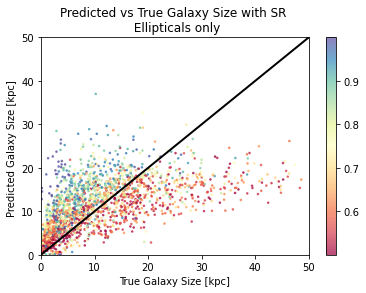

In [23]:
plt.scatter(y_ellipticals_imp, model_ellipticals_imp.predict(X_ellipticals_imp),
            c = df_ellipticals['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7) #,label= label, vmin=-2, vmax=1.0)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,50, 0.0,50])
plt.title('Predicted vs True Galaxy Size with SR \n Ellipticals only')
plt.xlabel('True Galaxy Size [kpc]')
plt.ylabel('Predicted Galaxy Size [kpc] ')
plt.colorbar()
# plt.savefig('SR_ellipticals_predicted vs true gal size.jpeg', dpi=500)
plt.show()

## <font color='purple'> <a id =5> </a> <br> SR Disk Galaxies

Randomly sample df_disks to extract 10,000 galaxies out of total ~15,000 beause SR works with at most 10,000 entries


In [14]:
df_disks_sample = df_disks.sample(n = 5000, random_state = 2022) #choose a subset of randomly sampled data

In [15]:
df_disks_sample.shape

(5000, 33)

In [16]:
# choose the 7 most important features from analysis above to be used for SR modelling

X_disks_imp = df_disks_sample.loc[:, ['HalopropSpin', 'GalpropNormVdisk',
                              'GalpropNormMHI', 'HalopropC_nfw', 'GalpropNormMbulge',
                              'GalpropNormMH2', 'GalpropNormMstar' ]]


y_disks_imp = df_disks_sample.loc[:, 'GalpropNormHalfRadius']

In [20]:
# choose the Symbolic Regression model; choose the mathematical operations allowed
model_disks_imp = PySRRegressor(

    niterations=10,
    binary_operators=["+", "*", "pow", ],
    unary_operators=["exp", "square", "cube", 
        "inv(x) = 1/x",  # Custom operator (julia syntax)
    ],
    constraints={
        "pow": (-1, 1),
#         "sqrt": 5,
    },
    
    maxsize=30,
    multithreading=False,
    model_selection="best",
    loss="loss(x, y) = (x - y)^2"  # Custom loss function (julia syntax)
)

In [21]:
start_time = time.time()

model_disks_imp.fit(X_disks_imp, np.array(y_disks_imp))

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the Disks SymbolicRegression fitting: {elapsed_time:.3f} seconds")

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pysr/sr.py:1067: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
  Activating project at `~/.julia/environments/pysr-0.9.3`
   Resolving package versions...
  No Changes to `~/.julia/environments/pysr-0.9.3/Project.toml`
  No Changes to `~/.julia/environments/pysr-0.9.3/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pysr-0.9.3/Project.toml`
  No Changes to `~/.julia/environments/pysr-0.9.3/Manifest.toml`
  No Changes to `~/.julia/environments/pysr-0.9.3/Project.toml`
  No Changes to `~/.julia/environments/pysr-0.9.3/Manifest.toml`


Activating environment on workers.
      From worker 9:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 2:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 3:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 5:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 6:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 4:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 8:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 7:	  Activating project at `~/.julia/environments/pysr-0.9.3`
Importing installed module on workers...      From worker 7:	WARNING: ignoring conflicting import of CoreModule.div into SymbolicRegression
      From worker 9:	WARNING: ignoring conflicting import of CoreModule.div into SymbolicRegression
      From worker 4:	WARNING: ignoring conflicting import of CoreModule.div into Symb

In [24]:
print(model_disks_imp)

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          30.744314   
	1         0.448642                         (HalopropSpin * 735.47736)   
	2         0.131215             ((HalopropSpin * 637.3735) + 7.903836)   
	3         0.000014  ((HalopropSpin * (636.37195 + HalopropSpin)) +...   
	4         0.005516  ((HalopropSpin * 636.37195) + (7.9039917 + (Ga...   
	5         0.082368  pow((square(exp(cube(exp(HalopropSpin)))) * -1...   
	6         0.056783  pow(((square(exp(cube(exp(HalopropSpin)))) * -...   
	7         0.179998  pow(((square(exp(cube(exp(HalopropSpin)))) * -...   
	8         0.040063  (square(cube((pow(pow(HalopropSpin * 0.4522493...   
	9   >>>>  0.580489  (square(cube((pow(pow(HalopropSpin * -0.531997...   
	10        0.028670  (square(cube((pow(pow(HalopropSpin * -0.531997...   
	11        0.015557  ((square(cube((pow(pow((HalopropSpin * -0.5319...   
	12      

In [25]:
model_disks_imp.equations_

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pysr/sr.py:910: FutureWarning: PySRRegressor.equations is now deprecated. Please use PySRRegressor.equations_ instead.
  warnings.warn(


,complexity,loss,score,equation,sympy_format,lambda_format
0,1,247.398680,0.000000,30.744314,30.7443140000000,PySRFunction(X=>30.7443140000000)
1,3,100.858330,0.448642,(HalopropSpin * 735.47736),735.47736*HalopropSpin,PySRFunction(X=>735.47736*HalopropSpin)
2,5,77.578220,0.131215,((HalopropSpin * 637.3735) + 7.903836),637.3735*HalopropSpin + 7.903836,PySRFunction(X=>637.3735*HalopropSpin + 7.903836)
3,7,77.576090,0.000014,((HalopropSpin * (636.37195 + HalopropSpin)) +...,HalopropSpin*(HalopropSpin + 636.37195) + 7.90...,PySRFunction(X=>HalopropSpin*(HalopropSpin + 6...
4,9,76.725020,0.005516,((HalopropSpin * 636.37195) + (7.9039917 + (Ga...,-1.2943748*GalpropNormVdisk + 636.37195*Halopr...,PySRFunction(X=>-1.2943748*GalpropNormVdisk + ...
5,12,59.926846,0.082368,pow((square(exp(cube(exp(HalopropSpin)))) * -1...,Abs(exp(GalpropNormVdisk) - 1.3304194*exp(2*ex...,PySRFunction(X=>Abs(exp(GalpropNormVdisk) - 1....
6,14,53.493390,0.056783,pow(((square(exp(cube(exp(HalopropSpin)))) * -...,Abs(GalpropNormVdisk**3 + GalpropNormVdisk - 1...,PySRFunction(X=>Abs(GalpropNormVdisk**3 + Galp...
7,15,44.681507,0.179998,pow(((square(exp(cube(exp(HalopropSpin)))) * -...,Abs(2*GalpropNormVdisk**3 - 1.3304194*exp(2*ex...,PySRFunction(X=>Abs(2*GalpropNormVdisk**3 - 1....
8,17,41.241070,0.040063,(square(cube((pow(pow(HalopropSpin * 0.4522493...,10.0818993156758*(HalopropSpin + (0.45224932*A...,PySRFunction(X=>10.0818993156758*(HalopropSpin...
9,19,12.915866,0.580489,(square(cube((pow(pow(HalopropSpin * -0.531997...,11.1318732038522*((0.5319979*Abs(HalopropSpin)...,PySRFunction(X=>11.1318732038522*((0.5319979*A...


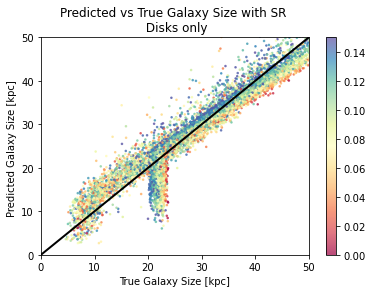

In [27]:
plt.scatter(y_disks_imp, model_disks_imp.predict(X_disks_imp),
            c = df_disks_sample['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7) #,label= label, vmin=-2, vmax=1.0)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,50, 0.0,50])
plt.title('Predicted vs True Galaxy Size with SR \n Disks only')
plt.xlabel('True Galaxy Size [kpc]')
plt.ylabel('Predicted Galaxy Size [kpc] ')
plt.colorbar()
# plt.savefig('SR_disks_predicted vs true gal size.jpeg', dpi=500)
plt.show()